# Credits
> This code is a slight modification to a translation (TensorFlow --> PyTorch) of a previous version of the [02456](http://kurser.dtu.dk/course/02456) course material. 
> [Original repo link (TensorFlow)](https://github.com/DeepLearningDTU/02456-deep-learning).
> [Translated repo link (PyTorch)](https://github.com/munkai/pytorch-tutorial/tree/master/2_intermediate).

In [52]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST

In [53]:
# Switch to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST dataset
MNIST is a dataset that is often used for benchmarking. The MNIST dataset consists of 70,000 images of handwritten digits from 0-9. The dataset is split into a 50,000 images training set, 10,000 images validation set and 10,000 images test set. The images are 28x28 pixels, where each pixel represents a normalised value between 0-255 (0=black and 255=white).

![MNIST.Exampel](../static_files/mnist.png)


## Primer
We use a feedforward neural network to classify the 28x28 mnist images. `num_features` is therefore $28 * 28=784$, i.e. we represent each image as a vector. The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance. (You are of course encouraged to try this using ``numpy.random.permutation`` to get a random permutation. This task is therefore called the _permutation invariant_ MNIST. Obviously this throws away a lot of structure in the data. In the next module we'll fix this with the convolutional neural network wich encodes prior knowledgde about data that has either spatial or temporal structure.  

## MNIST
First let's load the MNIST dataset and plot a few examples:

In [54]:
mnist_trainset = MNIST("./temp/", train=True, download=True)
mnist_testset = MNIST("./temp/", train=False, download=True)

In [55]:
# To speed up training we'll only work on a subset of the data
x_train = mnist_trainset.data[:1000].view(-1, 784).float().to(device)
targets_train = mnist_trainset.targets[:1000].to(device)

x_valid = mnist_trainset.data[1000:1500].view(-1, 784).float().to(device)
targets_valid = mnist_trainset.targets[1000:1500].to(device)

x_test = mnist_testset.data[:500].view(-1, 784).float().to(device)
targets_test = mnist_testset.targets[:500].to(device)

# normalize the inputs
x_train.div_(255)
x_valid.div_(255)
x_test.div_(255)

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train torch.Size([1000, 784])
targets_train torch.Size([1000])
x_valid torch.Size([500, 784])
targets_valid torch.Size([500])
x_test torch.Size([500, 784])
targets_test torch.Size([500])


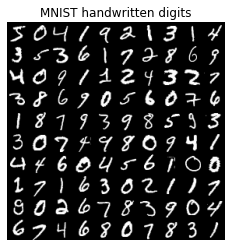

In [56]:
# plot a few MNIST examples
idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim)).cpu()
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

## Model

One of the large challenges in deep learning is the amount of hyperparameters that needs to be selected, and the lack of a good principled way of selecting them.
Hyperparameters can be found by experience (guessing) or some search procedure (often quite slow).
Random search is easy to implement and performs decent: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf . 
More advanced search procedures include [Spearmint](https://github.com/JasperSnoek/spearmint) and many others.

**In practice a lot of trial and error is almost always involved.** This can be frustrating and time consuming, but the best thing to do is to think as a scientist, and go about it in a ordered manner --> monitor as much as you can, take notes, and be deliberate!

Below are some guidelines that you can use as a starting point to some of the most important hyperparameters. 
(*regularization* is also very important, but will be covered later.)


### Ballpark estimates of hyperparameters
__Number of hidden units and network structure:__
You'll have to experiment. One rarely goes below 512 units for feedforward networks (unless your are training on CPU...).
There's some research into stochastic depth networks: https://arxiv.org/pdf/1603.09382v2.pdf, but in general this is trial and error.

__Parameter initialization:__
Parameter initialization is extremely important.
PyTorch has a lot of different initializers, check the [PyTorch API](http://pytorch.org/docs/master/nn.html#torch-nn-init). Often used initializer are
1. Kaiming He
2. Xavier Glorot
3. Uniform or Normal with small scale (0.1 - 0.01)
4. Orthogonal (this usually works very well for RNNs)

Bias is nearly always initialized to zero using the [torch.nn.init.constant(tensor, val)](http://pytorch.org/docs/master/nn.html#torch.nn.init.constant)

__Mini-batch size:__
Usually people use 16-256. Bigger is not allways better. With smaller mini-batch size you get more updates and your model might converge faster. Also small batch sizes use less memory, which means you can train a model with more parameters.

__Nonlinearity:__ [The most commonly used nonliearities are](http://pytorch.org/docs/master/nn.html#non-linear-activations)
1. ReLU
2. Leaky ReLU
3. ELU
3. Sigmoid (rarely, if ever, used in hidden layers anymore, squashes the output to the interval [0, 1] - appropriate if the targets are binary.
4. Tanh is similar to the sigmoid, but squashes to [-1, 1]. Rarely used any more.
4. Softmax normalizes the output to 1, usrful if you have a multi-class classification problem.

See the plot below.

__Optimizer and learning rate:__
1. SGD + Momentum: learning rate 0.01 - 0.1 
2. ADAM: learning rate 3e-4 - 1e-5
3. RMSPROP: somewhere between SGD and ADAM


softmax should sum to one (approxiamtely): 1.0


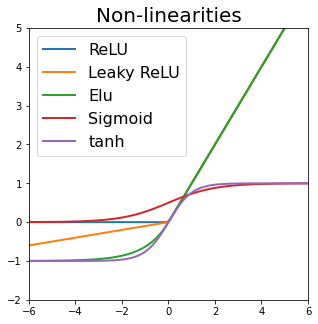

In [57]:
# Illustrate different output units
x = np.linspace(-6, 6, 100)
units = {
    "ReLU": lambda x: np.maximum(0, x),
    "Leaky ReLU": lambda x: np.maximum(0, x) + 0.1 * np.minimum(0, x),
    "Elu": lambda x: (x > 0) * x + (1 - (x > 0)) * (np.exp(x) - 1),
    "Sigmoid": lambda x: (1 + np.exp(-x))**(-1),
    "tanh": lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
}

plt.figure(figsize=(5, 5))
[plt.plot(x, unit(x), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Non-linearities', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])

# assert that all class probablities sum to one
softmax = lambda x: np.exp(x) / np.sum(np.exp(x))
print("softmax should sum to one (approxiamtely):", np.sum(softmax(x)))

In [58]:
#Hyperparameters
# Number of nodes in NN layers
num_classes = 10
num_l1 = 256
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        return x


net = Net(num_features, num_l1, num_classes).to(device)

In [59]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss().to(device) # Loss function

[[ 1.351708    0.16131444  0.8088245  ... -0.55881786  1.4079255
  -0.7794474 ]
 [ 1.458433    0.30273935 -2.5411246  ... -1.9716097   0.948214
  -0.66230625]
 [-0.11025617 -1.0878063   2.2337894  ... -0.1182844  -2.1032143
   0.56167495]
 ...
 [ 1.5783113   1.6918069   0.07484173 ...  2.5241902   1.219338
  -0.993398  ]
 [-0.26258245  0.5685911  -1.5374686  ...  0.94836813 -0.3038139
   2.0140455 ]
 [ 0.935613   -0.4202515   1.0210243  ...  0.7127524   1.2634152
  -1.1226647 ]]
torch.Size([45, 10])


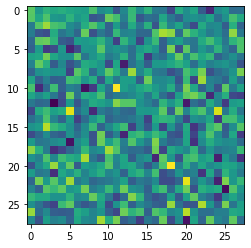

In [60]:
# Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')
print(x)
plt.imshow(x[0, :].reshape(28,28))
print(net(torch.from_numpy(x).to(device)).size())

# Build the training loop

We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches. Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples. The paramters are updated after each mini batch. Networks converge much faster using mini batches because the parameters are updated more often.

We build a loop that iterates over the training data. Remember that the parameters are updated each time ``optimizer.step()`` is called.

In [61]:
def TrainNetwork(
    Network,
    Optimizer = optim.SGD(net.parameters(), lr=0.01),
    Loss = nn.CrossEntropyLoss(),
    batch_size = 100,
    num_epochs = 200
    ):
  ## Train network
  # we could have done this ourselves,
  # but we should be aware of sklearn and its tools
  from sklearn.metrics import accuracy_score

  # setting hyperparameters  
  num_samples_train = x_train.shape[0]
  num_batches_train = num_samples_train // batch_size
  num_samples_valid = x_valid.shape[0]
  num_batches_valid = num_samples_valid // batch_size

  # setting up lists for handling loss/accuracy
  train_acc, train_loss = [], []
  valid_acc, valid_loss = [], []
  test_acc, test_loss = [], []
  cur_loss = 0
  losses = []

  get_slice = lambda i, size: range(i * size, (i + 1) * size)

  print("Starting training using {} epochs...".format(num_epochs))
  for epoch in range(1, num_epochs + 1):
      # Forward -> Backprob -> Update params
      ## Train
      cur_loss = 0
      net.train()
      for i in range(num_batches_train):
          Optimizer.zero_grad()
          slce = get_slice(i, batch_size)
          output = Network(x_train[slce])
          
          # compute gradients given loss
          target_batch = targets_train[slce]
          batch_loss = Loss(output, target_batch)
          batch_loss.backward()
          Optimizer.step()
          
          cur_loss += batch_loss   
      losses.append(cur_loss / batch_size)

      Network.eval()
      ### Evaluate training
      train_preds, train_targs = [], []
      for i in range(num_batches_train):
          slce = get_slice(i, batch_size)
          output = Network(x_train[slce])
          
          preds = torch.max(output, 1)[1]
          
          train_targs += list(targets_train[slce].cpu().numpy())
          train_preds += list(preds.data.cpu().numpy())
      
      ### Evaluate validation
      val_preds, val_targs = [], []
      for i in range(num_batches_valid):
          slce = get_slice(i, batch_size)
          
          output = Network(x_valid[slce])
          preds = torch.max(output, 1)[1]
          val_targs += list(targets_valid[slce].cpu().numpy())
          val_preds += list(preds.data.cpu().numpy())
          

      train_acc_cur = accuracy_score(train_targs, train_preds)
      valid_acc_cur = accuracy_score(val_targs, val_preds)
      
      train_acc.append(train_acc_cur)
      valid_acc.append(valid_acc_cur)
      
      if epoch % int(num_epochs/10) == 0:
          print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                  epoch, losses[-1], train_acc_cur, valid_acc_cur))

  print("Training completed with a final validation error of {}.".format(valid_acc_cur))

  epoch = np.arange(len(train_acc))
  plt.figure()
  plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
  plt.legend(['Train Accucary','Validation Accuracy'])
  plt.xlabel('Updates'), plt.ylabel('Acc')
  
  return

Starting training using 200 epochs...
Epoch 20 : Train Loss 0.083790 , Train acc 0.841000, Valid acc 0.778000
Epoch 40 : Train Loss 0.056330 , Train acc 0.879000, Valid acc 0.824000
Epoch 60 : Train Loss 0.044995 , Train acc 0.895000, Valid acc 0.838000
Epoch 80 : Train Loss 0.038409 , Train acc 0.912000, Valid acc 0.836000
Epoch 100 : Train Loss 0.033902 , Train acc 0.920000, Valid acc 0.848000
Epoch 120 : Train Loss 0.030505 , Train acc 0.925000, Valid acc 0.844000
Epoch 140 : Train Loss 0.027784 , Train acc 0.930000, Valid acc 0.844000
Epoch 160 : Train Loss 0.025511 , Train acc 0.937000, Valid acc 0.848000
Epoch 180 : Train Loss 0.023558 , Train acc 0.945000, Valid acc 0.852000
Epoch 200 : Train Loss 0.021846 , Train acc 0.950000, Valid acc 0.852000
Training completed with a final validation error of 0.852.


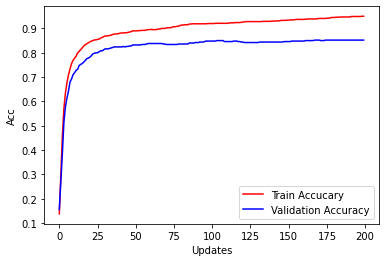

In [62]:
TrainNetwork(net)

# Assignments

Try and add these modifications (might require some Googleing -- an important skill in deep learning):
- Kaiming He initialization instead of Xavier Glorot
- add an extra layer
- use the relu activation function
- add momentum to the optimizer
- use the ADAM optimizer instead of stochastic gradient descent

### Advanced - Regularization

Regularization is VERY important in practice and is used practically every time.
Many important results are completely dependent on clever use of regularization, and it is something you need to become familiar with if you want to work with deep learning.

- add L1 or L2 weight regularization (aka. weight decay) 
- add dropout to the network (**note** the `net.train()` and `net.eval()` are already in the code)
- add batchnorm

__Pointers on regularization hyperparameter:__
1. L2 and [L1 regularization](http://pytorch.org/docs/master/nn.html#torch.nn.L1Loss) (weight decay of optimization functions) 
  - Normal ranges: 1e-4  -  1e-8
1. [Dropout](http://pytorch.org/docs/master/nn.html?highlight=dropout#torch.nn.Dropout). Dropout rate 0.1-0.5
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate random dropout, and call `net.eval()` to deactivate dropout while validating or running inference with model.
1. [Batchnorm](http://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm1d): Batchnorm also acts as a regularizer - Often very useful (faster and better convergence)
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate, and call `net.eval()` to have a non-stochastic variant while validating or running inference with model.
    

# Modifying the network
- Using Kaiming He initialization
- Having 2 hidden layers of 512 and 256 nodes respectively
- Using the ReLU activation function

In [63]:
## Define network
# Hyperparameters
# Number of nodes in NN layers
num_classes = 10
num_l1 = 512
num_l2 = 256
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_output, dropout_p=.0, use_batchnorm=False):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden_1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden_1), 0))
        self.activation_1 = torch.nn.ReLU() # activation function
        # hidden layer 1
        self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden_2, num_hidden_1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden_2), 0))
        self.activation_2 = torch.nn.ReLU() # activation function
        # hidden layer 2
        self.W_3 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden_2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        self.activation_3 = torch.nn.Identity() # activation function
        
        # batchnorms
        self.dropout = nn.Dropout(dropout_p)
        self.use_batchnorm = use_batchnorm
        if use_batchnorm:
          self.batchnorm_1 = nn.BatchNorm1d(num_hidden_1)
          self.batchnorm_2 = nn.BatchNorm1d(num_hidden_2)


    def forward(self, x):
        # Layer 1
        x = F.linear(x, self.W_1, self.b_1)
        x = self.dropout(x)
        if self.use_batchnorm:
          x = self.batchnorm_1(x)
        x = self.activation_1(x)
        
        # Layer 2
        x = F.linear(x, self.W_2, self.b_2)
        x = self.dropout(x)
        if self.use_batchnorm:
          x = self.batchnorm_2(x)
        x = self.activation_2(x)
        
        # Layer 3 - Output
        x = F.linear(x, self.W_3, self.b_3)
        x = self.activation_3(x)
  
        return x



loss = nn.CrossEntropyLoss().to(device) # Loss function

# Adding momentum to SGD

Starting training using 200 epochs...
Epoch 20 : Train Loss 0.044212 , Train acc 0.912000, Valid acc 0.848000
Epoch 40 : Train Loss 0.025154 , Train acc 0.953000, Valid acc 0.866000
Epoch 60 : Train Loss 0.016775 , Train acc 0.975000, Valid acc 0.874000
Epoch 80 : Train Loss 0.011692 , Train acc 0.986000, Valid acc 0.886000
Epoch 100 : Train Loss 0.008364 , Train acc 0.996000, Valid acc 0.884000
Epoch 120 : Train Loss 0.006178 , Train acc 0.999000, Valid acc 0.888000
Epoch 140 : Train Loss 0.004736 , Train acc 1.000000, Valid acc 0.886000
Epoch 160 : Train Loss 0.003760 , Train acc 1.000000, Valid acc 0.884000
Epoch 180 : Train Loss 0.003070 , Train acc 1.000000, Valid acc 0.884000
Epoch 200 : Train Loss 0.002565 , Train acc 1.000000, Valid acc 0.884000
Training completed with a final validation error of 0.884.


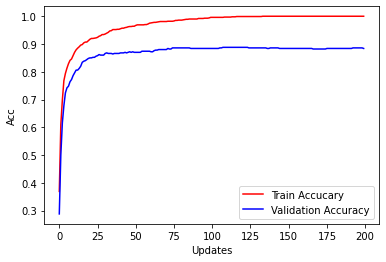

In [64]:
## Define network and optimizer
largerNet = Net(num_features, num_l1, num_l2, num_classes).to(device)
SGD_momentum = optim.SGD(largerNet.parameters(), lr=0.01, momentum=0.5)

## Train network
TrainNetwork(largerNet, SGD_momentum, loss)

# Using the ADAM optimizer

Starting training using 200 epochs...
Epoch 20 : Train Loss 0.000010 , Train acc 1.000000, Valid acc 0.878000
Epoch 40 : Train Loss 0.000002 , Train acc 1.000000, Valid acc 0.876000
Epoch 60 : Train Loss 0.000001 , Train acc 1.000000, Valid acc 0.876000
Epoch 80 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.878000
Epoch 100 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.880000
Epoch 120 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.880000
Epoch 140 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.880000
Epoch 160 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.880000
Epoch 180 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.878000
Epoch 200 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.878000
Training completed with a final validation error of 0.878.


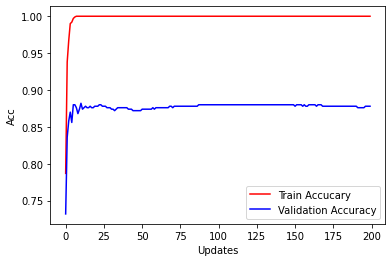

In [65]:
## Define network and optimizer
largerNet = Net(num_features, num_l1, num_l2, num_classes).to(device)
ADAM_optimizer = optim.Adam(largerNet.parameters(), lr=0.01)

## Train network
TrainNetwork(largerNet, ADAM_optimizer, loss)

# Adding regularization

Starting training using 200 epochs...
Epoch 20 : Train Loss 0.075165 , Train acc 0.859000, Valid acc 0.790000
Epoch 40 : Train Loss 0.043318 , Train acc 0.913000, Valid acc 0.838000
Epoch 60 : Train Loss 0.031439 , Train acc 0.938000, Valid acc 0.854000
Epoch 80 : Train Loss 0.024664 , Train acc 0.954000, Valid acc 0.856000
Epoch 100 : Train Loss 0.019983 , Train acc 0.961000, Valid acc 0.856000
Epoch 120 : Train Loss 0.016451 , Train acc 0.969000, Valid acc 0.858000
Epoch 140 : Train Loss 0.013683 , Train acc 0.977000, Valid acc 0.858000
Epoch 160 : Train Loss 0.011473 , Train acc 0.985000, Valid acc 0.866000
Epoch 180 : Train Loss 0.009692 , Train acc 0.993000, Valid acc 0.868000
Epoch 200 : Train Loss 0.008249 , Train acc 0.995000, Valid acc 0.872000
Training completed with a final validation error of 0.872.


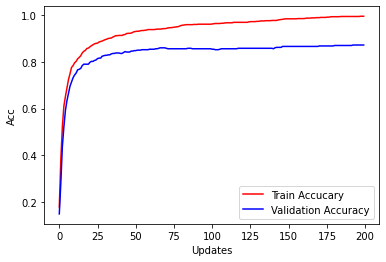

In [66]:
## Define network and optimizer
largerNet = Net(num_features, num_l1, num_l2, num_classes).to(device)
SGD_optimizer = optim.SGD(largerNet.parameters(), lr=0.01, weight_decay=1e-6)

## Train network
TrainNetwork(largerNet, SGD_optimizer, loss)

# Adding dropout


Starting training using 200 epochs...
Epoch 20 : Train Loss 0.012446 , Train acc 0.961000, Valid acc 0.796000
Epoch 40 : Train Loss 0.000005 , Train acc 1.000000, Valid acc 0.846000
Epoch 60 : Train Loss 0.000002 , Train acc 1.000000, Valid acc 0.848000
Epoch 80 : Train Loss 0.000001 , Train acc 1.000000, Valid acc 0.852000
Epoch 100 : Train Loss 0.000001 , Train acc 1.000000, Valid acc 0.852000
Epoch 120 : Train Loss 0.000001 , Train acc 1.000000, Valid acc 0.852000
Epoch 140 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.852000
Epoch 160 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.852000
Epoch 180 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.852000
Epoch 200 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.852000
Training completed with a final validation error of 0.852.


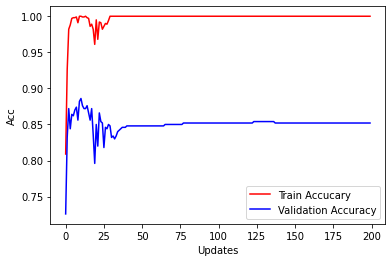

In [49]:
## Define network and optimizer
largerNet = Net(num_features, num_l1, num_l2, num_classes, dropout_p=.3).to(device)
ADAM_optimizer = optim.Adam(largerNet.parameters(), lr=0.01)

## Train network
TrainNetwork(largerNet, ADAM_optimizer, loss)

# Adding batchnorm

Starting training using 200 epochs...
Epoch 20 : Train Loss 0.011192 , Train acc 0.988000, Valid acc 0.860000
Epoch 40 : Train Loss 0.000002 , Train acc 1.000000, Valid acc 0.862000
Epoch 60 : Train Loss 0.000001 , Train acc 1.000000, Valid acc 0.864000
Epoch 80 : Train Loss 0.000001 , Train acc 1.000000, Valid acc 0.868000
Epoch 100 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.866000
Epoch 120 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.866000
Epoch 140 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.868000
Epoch 160 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.868000
Epoch 180 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.868000
Epoch 200 : Train Loss 0.000000 , Train acc 1.000000, Valid acc 0.868000
Training completed with a final validation error of 0.868.


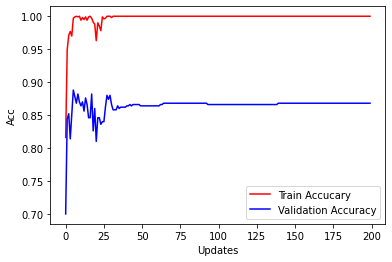

In [50]:
## Define network and optimizer
largerNet = Net(num_features, num_l1, num_l2, num_classes, use_batchnorm=True).to(device)
ADAM_optimizer = optim.Adam(largerNet.parameters(), lr=0.01)

## Train network
TrainNetwork(largerNet, ADAM_optimizer, loss)

# Experimenting with combinations

Starting training using 50 epochs...
Epoch  5 : Train Loss 0.002919 , Train acc 0.983000, Valid acc 0.827500
Epoch 10 : Train Loss 0.000052 , Train acc 1.000000, Valid acc 0.865000
Epoch 15 : Train Loss 0.000006 , Train acc 1.000000, Valid acc 0.870000
Epoch 20 : Train Loss 0.000003 , Train acc 1.000000, Valid acc 0.870000
Epoch 25 : Train Loss 0.000003 , Train acc 1.000000, Valid acc 0.865000
Epoch 30 : Train Loss 0.000002 , Train acc 1.000000, Valid acc 0.862500
Epoch 35 : Train Loss 0.000002 , Train acc 1.000000, Valid acc 0.862500
Epoch 40 : Train Loss 0.000001 , Train acc 1.000000, Valid acc 0.865000
Epoch 45 : Train Loss 0.000001 , Train acc 1.000000, Valid acc 0.865000
Epoch 50 : Train Loss 0.000001 , Train acc 1.000000, Valid acc 0.867500
Training completed with a final validation error of 0.8675.


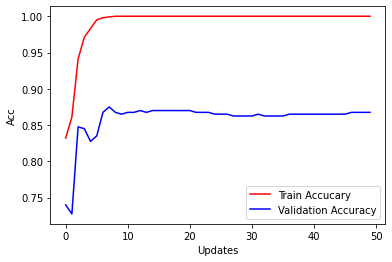

In [51]:
## Define network and optimizer
largerNet = Net(num_features, num_l1, num_l2, num_classes, dropout_p=.5, use_batchnorm=True).to(device)
ADAM_optimizer = optim.Adam(largerNet.parameters(), lr=0.01, weight_decay=1e-6)

## Train network
TrainNetwork(largerNet, ADAM_optimizer, loss, num_epochs=50, batch_size=200)

# Exercise from "Michael Nielsen"

*The exercise chosen is from Chapter 3 and states:*

Verify that:

\begin{align}
  \sigma'(z) = \sigma(z)(1-\sigma(z)).
\end{align}

**Solution** \
Initially, recall that,
\begin{align}
  \sigma(z) = \frac{1}{1+\exp(-z)},
\end{align}

which through use of the chainrule is seen to have the derivative,
\begin{align}
  \sigma'(z) &= -\frac{-\exp(-z)}{(1+\exp(-z))^2}, \\
  &= \frac{1}{1+\exp(-z)} \left( \frac{1+\exp(-z)-1}{1+\exp(-z)} \right), \\
  &= \frac{1}{1+\exp(-z)} \left( \frac{1+\exp(-z)}{1+\exp(-z)} - \frac{1}{1+\exp(-z)} \right), \\
  &= \sigma(z)(1-\sigma(z)).
\end{align}
$\square$


You are done for now. [Good job.](https://media1.tenor.com/images/0fd559b07f2174f9b8b7dbde7c5a67ca/tenor.gif)